# Compare and analyze the used models
Especially why they don't work.

In [3]:
import os
import re
from itertools import islice
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow.contrib.keras as keras

import vixstructure.data as data

## Naive stacking of fully-connected layers

### Number of hidden layers

The following plot compares the number of hidden layers (increasing from 1 to 10) and its influence on the resulting loss and accuracy (TODO: How is accuracy calculated?). The validation looks rather strange and its recommended to first check the implementation of the respective calculations.

In [3]:
relpath = "logs/naive-fully-connected"
dirtree = [dirtree for dirtree in os.walk("logs") if dirtree[0] == relpath][0]
filenames = [filename for filename in dirtree[2] if filename[-4:] == ".log"]
# Sort the files by number of hidden layers.
filenames.sort(key=lambda x: int(re.findall(r"""(?<=training_)[0-9]+(?=_)""", x)[0]))
csvdata = tuple(pd.read_csv(os.path.join(dirtree[0], filename), header=0, index_col=0, dtype=np.float32)
             for filename in filenames)

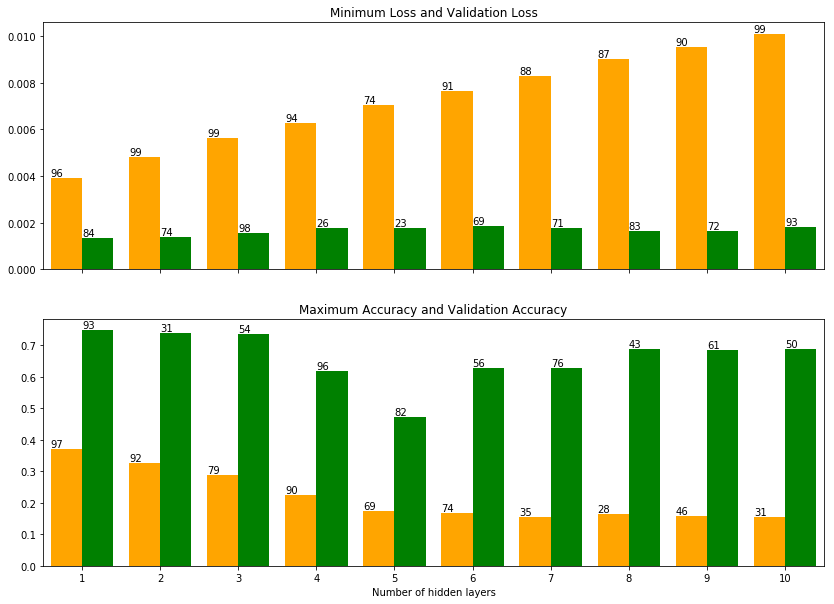

In [4]:
f, axs = plt.subplots(2, sharex=True)
f.set_size_inches(14, 10)
for idx, sample in enumerate(csvdata):
    rect = axs[0].bar(idx + 0.8, sample["loss"].min(), width=0.4, color="orange")
    axs[0].text(rect[0].get_x(), rect[0].get_height(), int(sample["loss"].argmin()) + 1, ha="left", va="bottom")
    rect = axs[0].bar(idx + 1.2, sample["val_loss"].min(), width=0.4, color="green")
    axs[0].text(rect[0].get_x(), rect[0].get_height(), int(sample["val_loss"].argmin()) + 1, ha="left", va="bottom")
axs[0].set_title("Minimum Loss and Validation Loss")
for idx, sample in enumerate(csvdata):
    rect = axs[1].bar(idx + 0.8, sample["acc"].max(), width=0.4, color="orange")
    axs[1].text(rect[0].get_x(), rect[0].get_height(), int(sample["acc"].argmax()) + 1, ha="left", va="bottom")
    rect = axs[1].bar(idx + 1.2, sample["val_acc"].max(), width=0.4, color="green")
    axs[1].text(rect[0].get_x(), rect[0].get_height(), int(sample["val_acc"].argmax()) + 1, ha="left", va="bottom")
axs[1].xaxis.set_ticks(np.arange(1, 11))
axs[1].set_title("Maximum Accuracy and Validation Accuracy")
axs[1].set_xlabel("Number of hidden layers")
axs[1].set_xlim(0.5,10.5)
plt.show()

The numbers above the bars represent the epoch number with the best results. The training was running for 100 epochs in total.

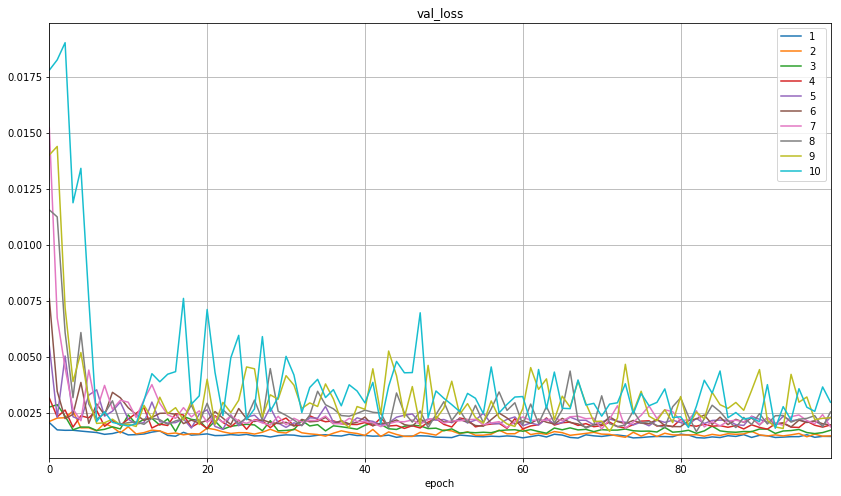

In [5]:
index_title = "val_loss"
for idx, d in enumerate(csvdata):
    d[index_title].plot(figsize=(14,8), label=idx + 1)
plt.title(index_title)
plt.legend()
plt.grid()
plt.show()

### Visualize predictions

Use the model with two hidden layers because the performance seems more stable.

In [6]:
model2 = keras.models.load_model("models/naive-fully-connected/naive_2_7_7.hdf5")
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 7, 9)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 63)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 63)                4032      
_________________________________________________________________
dropout_2 (Dropout)          (None, 63)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 63)                4032      
_________________________________________________________________
dropout_3 (Dropout)          (None, 63)                0         
_________________________________________________________________
output (Dense)               (None, 8)                 512       
Total para

In [7]:
def make_array(array_like) -> np.ndarray:
    return np.squeeze(np.array(array_like))
datalen, datagen = data.get_data_generators(7, 7, None)
datalist = list(islice(datagen, datalen))
inputdata, targetdata = zip(*datalist)
preds = data.denormalize(make_array([model2.predict(databatch) for databatch in inputdata]))
# Get non-normalized original data for targets
originaldata = data.get_data()
dates = originaldata.index.date
vix_data = originaldata.iloc[:,0].values
targetdata = originaldata.iloc[7:-7,1:].interpolate(axis=1).fillna(method="bfill", axis=1).values
assert len(preds) == datalen
assert len(inputdata) == datalen
assert len(targetdata) == datalen

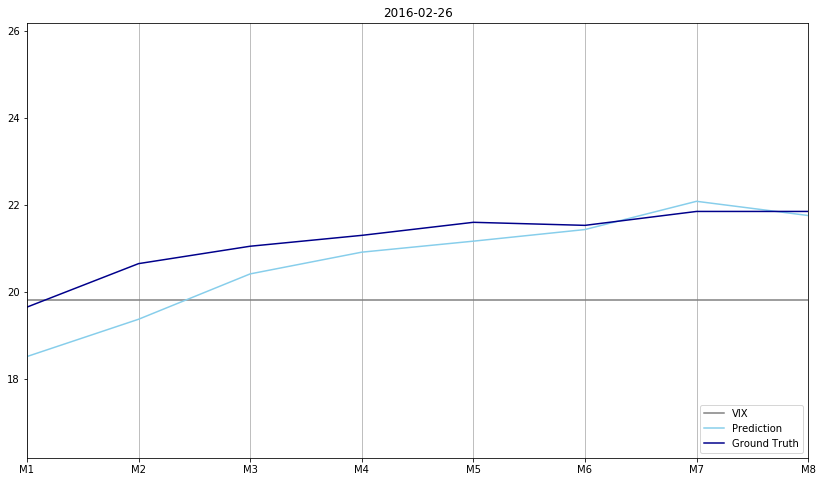

In [8]:
def plot_date(index: int, save: bool=False):
    x = np.arange(8)
    xlabels = tuple(f"M{i}" for i in range(1,9))
    plt.figure(figsize=(14,8))
    global vix_data
    plt.axhline(vix_data[index], color="gray")
    global preds
    plt.plot(x, np.squeeze(preds[index]), color="skyblue")
    global targetdata
    plt.plot(x, np.squeeze(targetdata[index]), color="darkblue")
    plt.xticks(x, xlabels)
    plt.xlim(0, 7)
    mean = targetdata[index].mean()
    plt.ylim(mean - 5, mean + 5)
    plt.grid(axis="x")
    global dates
    plt.title(dates[index])
    plt.legend(["VIX", "Prediction", "Ground Truth"], loc="lower right")
    if not save:
        plt.show()
    else:
        plt.savefig("prediction_term_structure_figures/{:04d}.png".format(index))
        plt.close()
plot_date(3000)

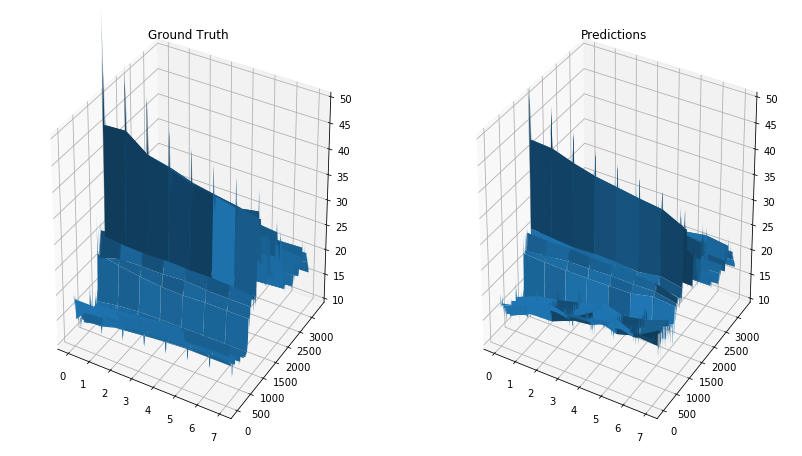

In [11]:
fig = plt.figure(figsize=(14, 8))
X, Y = np.meshgrid(np.arange(8), np.arange(3291))
ax0 = fig.add_subplot(121, projection='3d')
ax0.plot_surface(X, Y, targetdata)
ax0.set_zlim(10,50)
ax0.set_title("Ground Truth")
ax1 = fig.add_subplot(122, projection='3d')
ax1.plot_surface(X, Y, preds)
ax1.set_zlim(10,50)
ax1.set_title("Predictions")
plt.show()

## Predicting spread prices

### First let's have a look at the hyperparameters

In [108]:
relpath = "logs/predict_spread_prices"
dirtree = [dirtree for dirtree in os.walk("logs") if dirtree[0] == relpath][0]
filenames = [filename for filename in dirtree[2] if os.path.splitext(filename)[1] == ".csv"]
re_hyperparam = re.compile(r"""_(?P<layers>[0-9]{1,2})_(?P<dropout>nodropout|0.5)_(?P<step>0.[0-9]*)""")
# Parse hyperparameter information and convert types accordingly
hyperparams = (re_hyperparam.search(fn).groups() for fn in filenames)
hyperparams = map(lambda x: (int(x[0]), 0. if x[1] == "nodropout" else float(x[1]), float(x[2])), hyperparams)
hyperparams = sorted(zip(hyperparams, filenames), key=operator.itemgetter(0))
# Temporary: Filter out everything with more than 6 layers
hyperparams = list(filter(lambda x: x[0][0] <= 6, hyperparams))

In [181]:
csv_data = [pd.read_csv(os.path.join(dirtree[0], hp[1]), header=0, index_col=0, usecols=(0,4),
                                     squeeze=True, dtype=np.float32)
            for hp in hyperparams]
logdata = pd.DataFrame(csv_data)
logdata.index = np.arange(len(logdata))
index_values = pd.DataFrame(np.array(list(zip(*hyperparams))[0], dtype=np.float32),
                          columns=("layers", "dropout", "step"))
logdata = index_values.join(logdata).set_index(["layers", "dropout", "step"])

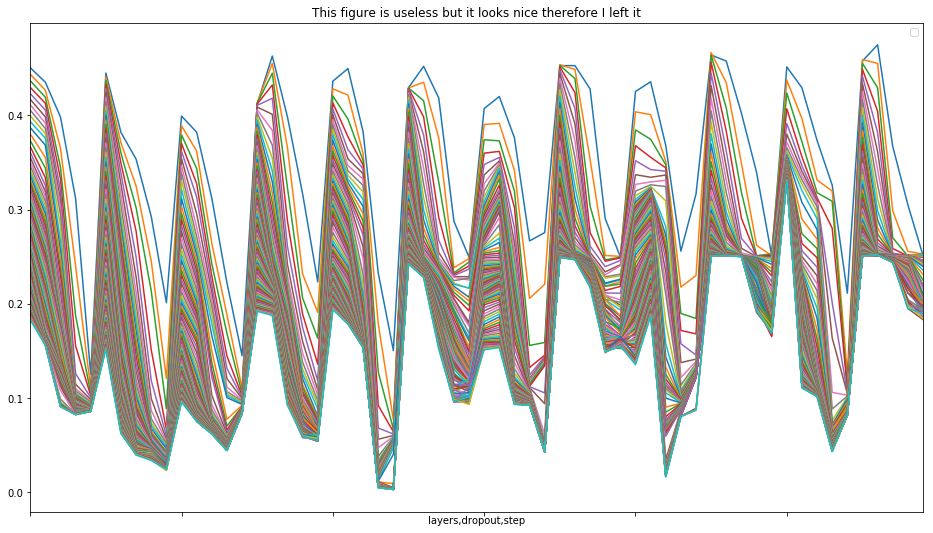

In [196]:
logdata.plot(figsize=(16,9))
plt.title("This figure is useless but it looks nice therefore I left it")
plt.legend("")
plt.tick_params(labelbottom="off")
plt.show()

In [222]:
best_models = pd.DataFrame(logdata.idxmin()).join(pd.DataFrame(logdata.min()), lsuffix="idx")
best_models.columns = ["hyperparameters", "loss"]
best_models

,hyperparameters,loss
0.0,"(1.0, 0.0, 0.00999999977648)",0.124821
1.0,"(3.0, 0.0, 0.00999999977648)",0.076611
2.0,"(3.0, 0.0, 0.00999999977648)",0.066925
3.0,"(3.0, 0.0, 0.00999999977648)",0.063961
4.0,"(1.0, 0.5, 0.00999999977648)",0.059712
5.0,"(1.0, 0.5, 0.00999999977648)",0.055878
6.0,"(3.0, 0.0, 0.00300000002608)",0.047056
7.0,"(3.0, 0.0, 0.00300000002608)",0.037850
8.0,"(3.0, 0.0, 0.00300000002608)",0.034169
9.0,"(3.0, 0.0, 0.00300000002608)",0.032246


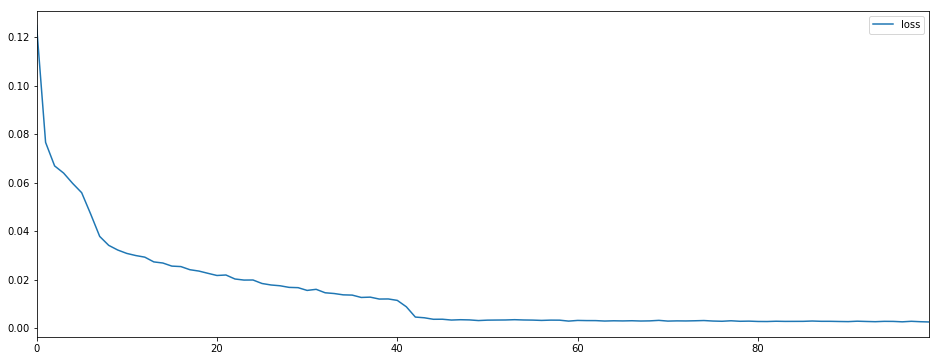

In [227]:
best_models.plot(figsize=(16,6))
plt.show()

Note that the best models are only these without dropout. Since no further regularization was introduced this may be a sign of **overfitting**. Maybe the validation data is too easy to predict when the model is overfitting or there are some strange shortcuts the model found.

So what about the models with dropout?

In [225]:
logdata.query("dropout == 0.5").min()[-10:]

90.0    0.024491
91.0    0.024747
92.0    0.024310
93.0    0.023983
94.0    0.024633
95.0    0.023753
96.0    0.023836
97.0    0.023856
98.0    0.022668
99.0    0.024287
dtype: float32

The performance of the best model with dropout (loss: 0.0227) is much worse than the best model without (loss: 0.0025). It's nine times as bad! But maybe there is less overfitting? Might it actually be a good idea to use deeper models with dropout regularization? Seems like a useless idea but lets wait for more results.

### Actual prediction

Maybe taking a look at the actual predictions might help.

**PROBLEM:** Could not reproduce training run with the same parameters. **WTF?!**

In [6]:
model3 = keras.models.load_model("models/predict_spread_prices/annual_3_nodropout_0.001.hdf5")
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                156       
_________________________________________________________________
output (Dense)               (None, 12)                156       
Total params: 624.0
Trainable params: 624.0
Non-trainable params: 0.0
_________________________________________________________________


In [44]:
# Here I just copy some code over; TODO should really move this into a module.
def normalize(data: pd.DataFrame):
    mean = data.mean()
    ptp = data.max() - data.min()
    return (data - mean) / ptp
def denormalize(data, original_data):
    mean = original_data.mean()
    ptp = original_data.max() - original_data.min()
    return data * ptp.values + mean.values
lines_without_useful_data = 650
term_structure = pd.read_csv("data/annual_structure.csv", header=0, index_col=0, dtype=np.float32, parse_dates=[0],
                                 skiprows=lines_without_useful_data)
spread_prices = pd.read_csv("data/long_prices.csv", header=0, index_col=0, dtype=np.float32, parse_dates=[0],
                            skiprows=lines_without_useful_data)
assert len(term_structure) == len(spread_prices)
term_structure_norm = normalize(term_structure)
spread_prices_norm = normalize(spread_prices)
term_structure_norm = term_structure_norm.fillna(1.)
spread_prices_norm = spread_prices_norm.fillna(1.)
splitsize = int(len(term_structure_norm) * 0.8)
x_train = term_structure_norm.values[:splitsize]
y_train = spread_prices_norm.values[:splitsize]
x_val = term_structure_norm.values[splitsize:]
y_val = spread_prices_norm.values[splitsize:]

In [50]:
preds = model3.predict(x_val)
val = denormalize(y_val, spread_prices)
preds = denormalize(preds, spread_prices)

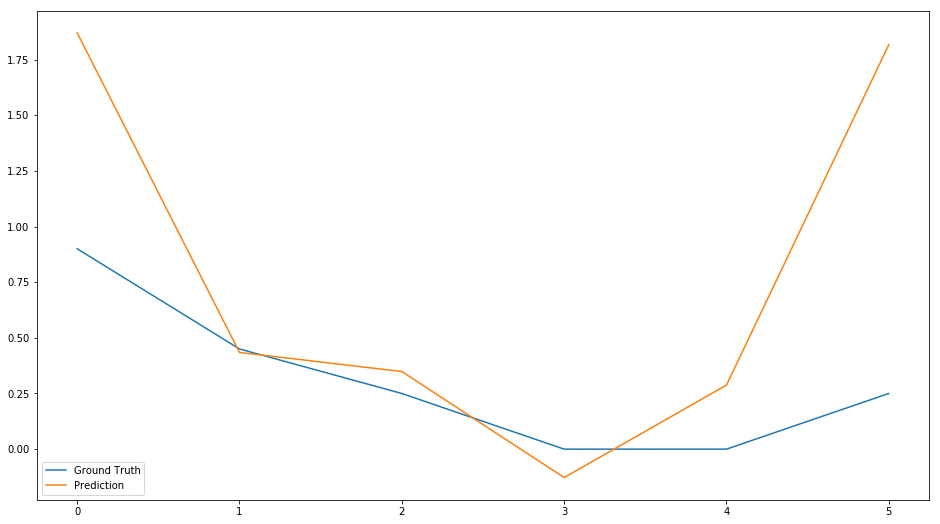

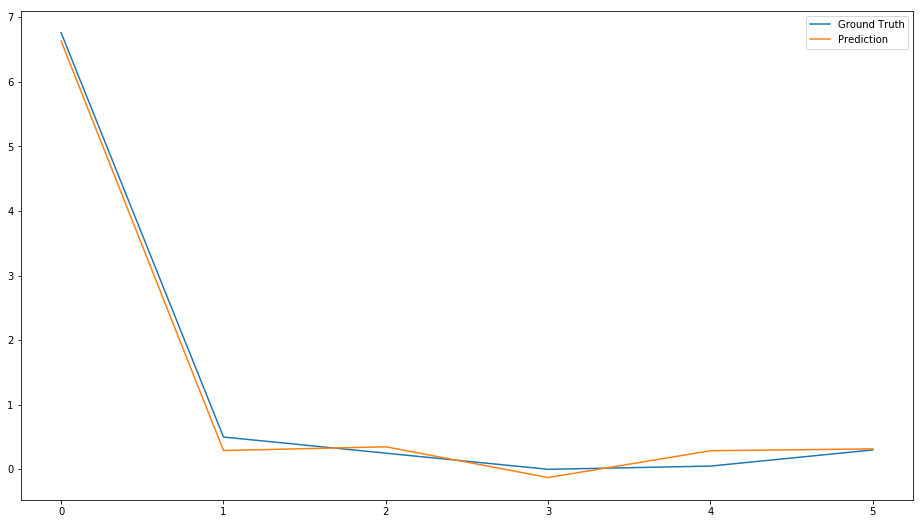

In [79]:
def plot_validation(index):
    plt.figure(figsize=(16,9))
    global val
    global preds
    plt.plot(np.arange(6), val[index,4:10], label="Ground Truth")
    plt.plot(np.arange(6), preds[index,4:10], label="Prediction")
    plt.legend()
    plt.show()
plot_validation(6)
plot_validation(7)